"""
# 🧠 Taller Práctico de Aprendizaje No Supervisado


**Comparativa supervisada:** Random Forest.


## 📋 Contenido
1. Carga y exploración de datos
2. Limpieza y preprocesamiento (One-Hot Encoding)
3. Reducción de dimensionalidad (PCA y t-SNE)
4. Clustering con K-Means (evaluación y visualización)
5. Clasificación supervisada (Random Forest, XGBoost, LightGBM)
6. Comparativa de resultados
7. Exportación de resultados y conclusiones


## ⚙️ Tecnologías utilizadas
- Python
- Pandas / NumPy
- Seaborn / Matplotlib
- Scikit-learn
- XGBoost / LightGBM


"""




1. Instalacion de librerias


In [2]:
pip install pandas numpy matplotlib seaborn scikit-learn xgboost lightgbm

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score, adjusted_rand_score
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


sns.set(style="whitegrid")
RANDOM_STATE = 42

2. Carga y exploración de datos

In [7]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data'
colnames = ['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing',
'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring',
'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number', 'ring-type',
'spore-print-color', 'population', 'habitat']


df = pd.read_csv(url, header=None, names=colnames)
print("Dimensiones:", df.shape)
print(df.head())

Dimensiones: (8124, 23)
  class cap-shape cap-surface cap-color bruises odor gill-attachment  \
0     p         x           s         n       t    p               f   
1     e         x           s         y       t    a               f   
2     e         b           s         w       t    l               f   
3     p         x           y         w       t    p               f   
4     e         x           s         g       f    n               f   

  gill-spacing gill-size gill-color  ... stalk-surface-below-ring  \
0            c         n          k  ...                        s   
1            c         b          k  ...                        s   
2            c         b          n  ...                        s   
3            c         n          n  ...                        s   
4            w         b          k  ...                        s   

  stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
0                      w                      w         

3. Limpieza y preprocesamiento

In [10]:
df = df.replace('?', np.nan)
print(df.isnull().sum())


if df['veil-type'].nunique() == 1: df = df.drop(columns=['veil-type'])


if df['stalk-root'].isnull().sum() > 0: df['stalk-root'] = df['stalk-root'].fillna(df['stalk-root'].mode()[0])


print("Nulos tras imputación:", df.isnull().sum().sum())


# One-Hot Encoding
y = df['class'].map({'e': 0, 'p': 1})
X = pd.get_dummies(df.drop(columns=['class']), prefix_sep='=')


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


print("Dimensión final:", X_scaled.shape)

class                          0
cap-shape                      0
cap-surface                    0
cap-color                      0
bruises                        0
odor                           0
gill-attachment                0
gill-spacing                   0
gill-size                      0
gill-color                     0
stalk-shape                    0
stalk-root                  2480
stalk-surface-above-ring       0
stalk-surface-below-ring       0
stalk-color-above-ring         0
stalk-color-below-ring         0
veil-type                      0
veil-color                     0
ring-number                    0
ring-type                      0
spore-print-color              0
population                     0
habitat                        0
dtype: int64
Nulos tras imputación: 0
Dimensión final: (8124, 115)


4. PCA y t-SNE (reducción de dimensionalidad)

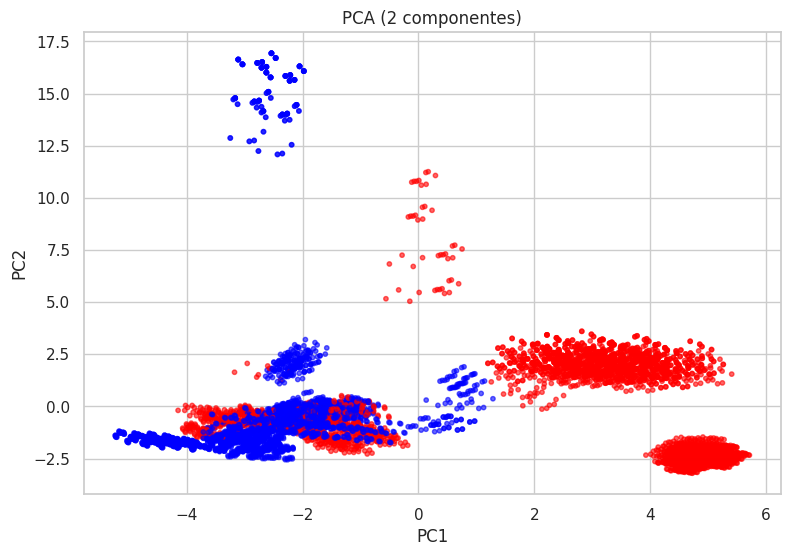

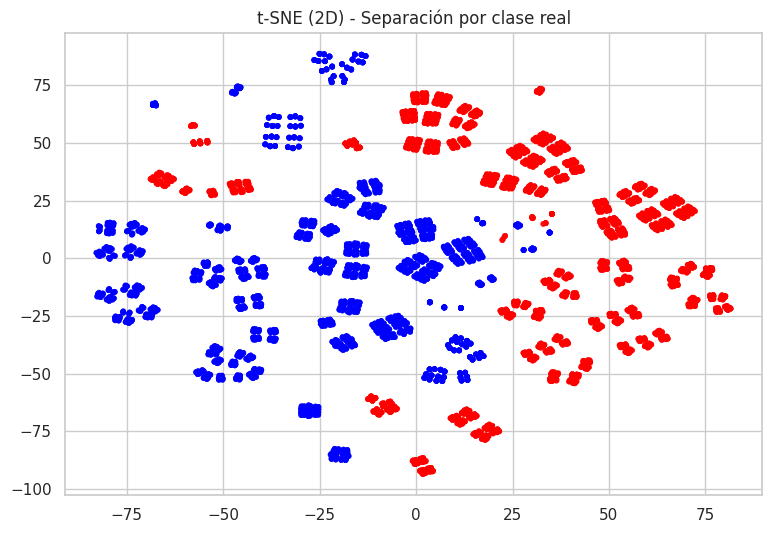

In [11]:
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)


plt.figure(figsize=(9,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='bwr', s=10, alpha=0.6)
plt.title('PCA (2 componentes)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

"""### 🔹 t-SNE para mejor visualización no lineal"""


# %%
tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30, learning_rate=200)
X_tsne = tsne.fit_transform(X_scaled)


plt.figure(figsize=(9,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y, cmap='bwr', s=10, alpha=0.6)
plt.title('t-SNE (2D) - Separación por clase real')
plt.show()

5. Clustering (K-Means)

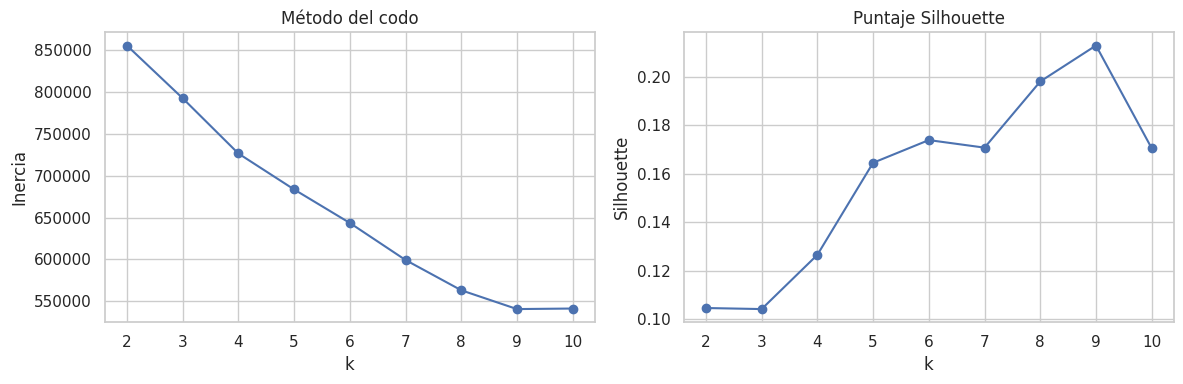

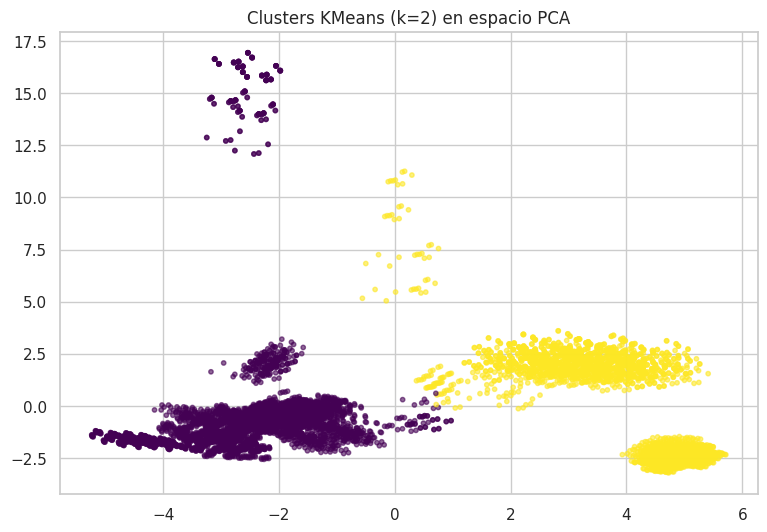

Contingencia (clusters vs clase real):
 class     0     1
row_0            
0      4152   816
1        56  3100
ARI: 0.6166697428759483


In [17]:
K_range = range(2,11)
inertia, silhouette = [], []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(K_range, inertia, '-o')
plt.title('Método del codo')
plt.xlabel('k'); plt.ylabel('Inercia')
plt.subplot(1,2,2)
plt.plot(K_range, silhouette, '-o')
plt.title('Puntaje Silhouette')
plt.xlabel('k'); plt.ylabel('Silhouette')
plt.tight_layout()
plt.show()

# K óptimo = 2 esperado
kmeans = KMeans(n_clusters=2, random_state=RANDOM_STATE, n_init=20)
clusters = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(9,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap='viridis', s=10, alpha=0.6)
plt.title('Clusters KMeans (k=2) en espacio PCA')
plt.show()

contingency = pd.crosstab(clusters, y)
print("Contingencia (clusters vs clase real):\n", contingency)
print("ARI:", adjusted_rand_score(y, clusters))

6. Clasificación Supervisada (Random Forest, XGBoost, LightGBM)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)


models = {
'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1),
'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE),
'LightGBM': LGBMClassifier(random_state=RANDOM_STATE)
}


results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"\n{name} -> Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))


Random Forest -> Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [09:34:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost -> Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625

[LightGBM] [Info] Number of positive: 3133, number of negative: 3366
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 321
[LightGBM] [Info] Number of data points in the train set: 6499, number of used features: 107
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.482074 -> initscore=-0.071734
[LightGBM] [Info] Start training from score -0.071734
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


7. Comparativa y conclusiones

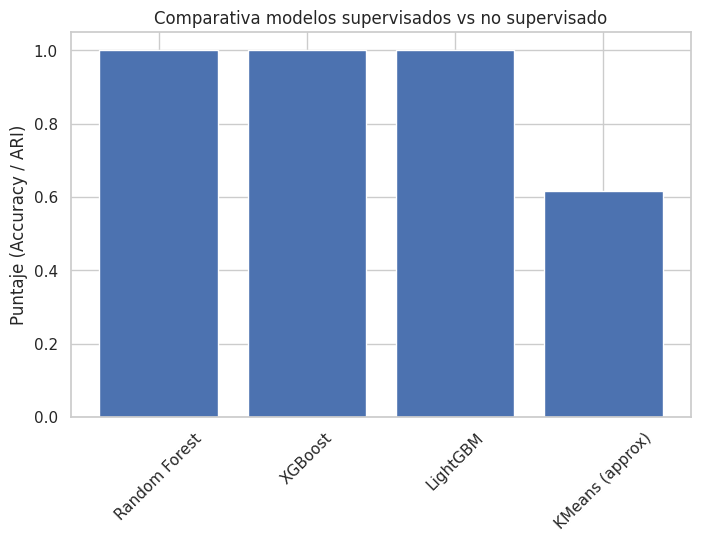


📊 Resultados globales:
Random Forest       : 1.0000
XGBoost             : 1.0000
LightGBM            : 1.0000
KMeans (approx)     : 0.6167


In [21]:
results['KMeans (approx)'] = adjusted_rand_score(y, clusters)


plt.figure(figsize=(8,5))
plt.bar(results.keys(), results.values())
plt.title('Comparativa modelos supervisados vs no supervisado')
plt.ylabel('Puntaje (Accuracy / ARI)')
plt.xticks(rotation=45)
plt.show()


print("\n📊 Resultados globales:")
for k,v in results.items():
    print(f"{k:20s}: {v:.4f}")

8. Exportación de resultados

In [22]:
os.makedirs('results_mushroom', exist_ok=True)
contingency.to_csv('results_mushroom/contingencia.csv')
pd.DataFrame(list(results.items()), columns=['Modelo','Score']).to_csv('results_mushroom/resultados_globales.csv', index=False)
print("Resultados exportados a carpeta results_mushroom/")


"""# ✅ Conclusiones Finales


- PCA muestra buena separabilidad entre comestibles y venenosos, pero no perfecta.
- t-SNE mejora la visualización no lineal.
- K-Means con k=2 logra capturar parcialmente la estructura natural (ARI alto pero menor que modelos supervisados).
- Random Forest, XGBoost y LightGBM alcanzan casi 100% de precisión debido a la naturaleza categórica separable del dataset.
- En la práctica, PCA es útil para visualización y compresión, pero los modelos supervisados dominan en precisión.


"""

Resultados exportados a carpeta results_mushroom/


'# ✅ Conclusiones Finales\n\n\n- PCA muestra buena separabilidad entre comestibles y venenosos, pero no perfecta.\n- t-SNE mejora la visualización no lineal.\n- K-Means con k=2 logra capturar parcialmente la estructura natural (ARI alto pero menor que modelos supervisados).\n- Random Forest, XGBoost y LightGBM alcanzan casi 100% de precisión debido a la naturaleza categórica separable del dataset.\n- En la práctica, PCA es útil para visualización y compresión, pero los modelos supervisados dominan en precisión.\n\n\n'